In [3]:
from kan import KAN
from scipy.integrate import solve_ivp
import torch
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random

random.seed(0)
#np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
torch.set_default_dtype(torch.float64)


In [4]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
#from kan import *


# Importar o arquivo CSV para um DataFrame do pandas
dados = pd.read_csv('C:/Users/beatr/Desktop/MySindy/pysindy/DadosArt1/dados_sir.csv')
# Construíndo arrays com dados S, I, R
S = np.array(dados['suscetiveis'])
I = np.array(dados['infectados'])

dSdt_real = np.array(dados['dSdt'])
dIdt_real = np.array(dados['dIdt'])
dRdt_real =np.array(dados['dRdt'])

# Converter dados para tensores PyTorch
S_tensor = torch.tensor(S, dtype=torch.float64)
I_tensor = torch.tensor(I, dtype=torch.float64)

dSdt_tensor = torch.tensor(dSdt_real, dtype=torch.float64).unsqueeze(1)  # dSdt = -beta * S * I + nu * R
dIdt_tensor = torch.tensor(dIdt_real, dtype=torch.float64)  # beta * S * I - gamma * I
dRdt_tensor = torch.tensor(dRdt_real, dtype=torch.float64)

# Combinar S, I em um tensor de entrada
inputs_tensor = torch.stack((S_tensor, I_tensor), dim=1)

# As derivadas em um único tensor de saída
outputs_tensor = dSdt_tensor

# Converter tensores para arrays NumPy para usar com train_test_split
inputs_np = inputs_tensor.numpy()
outputs_np = outputs_tensor.numpy()

# Dividir os dados em conjuntos de treino e teste
x_train, x_test, y_train, y_test = train_test_split(inputs_np, outputs_np, test_size=0.2, random_state=42)

# Converter os conjuntos de treino e teste de volta para tensores PyTorch
x_train_tensor = torch.tensor(x_train, dtype=torch.float64)
x_test_tensor = torch.tensor(x_test, dtype=torch.float64)
y_train_tensor = torch.tensor(y_train, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test, dtype=torch.float64)

# Criar o dataset
dataset = {
    'train_input': x_train_tensor,
    'train_label': y_train_tensor,
    'test_input': x_test_tensor,
    'test_label': y_test_tensor
}

# Verifique os resultados:
#print("Train input shape:", dataset['train_input'].shape)
#print("Test input shape:", dataset['test_input'].shape)
#print("Train label shape:", dataset['train_label'].shape)
#print("Test label shape:", dataset['test_label'].shape)
dataset['train_input'].shape, dataset['train_label'].shape
#dataset
#dataset['test_input'].shape, dataset['test_label'].shape7


(torch.Size([40000, 2]), torch.Size([40000, 1]))

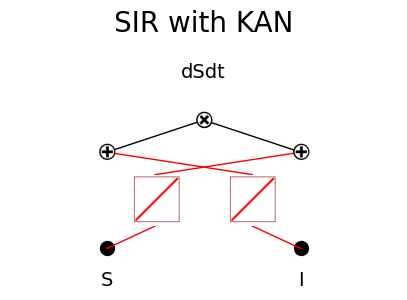

In [5]:
from kan.compiler import kanpiler
from sympy import symbols
import torch
# Definir dispositivo 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definindo as variáveis simbólicas
S, I = symbols('S I')
expr = - S * I  # A equação que você deseja ajustar

# Criar o modelo KAN a partir da equação simbólica
model = kanpiler([S, I], expr).to(device)  # Certifique-se que está na GPU (se disponível)
model.get_act(dataset)  # Visualiza as ativações antes de ajustar
model.plot(beta=15, in_vars=['S', 'I'], out_vars=['dSdt'], title='SIR with KAN', scale=0.50, varscale=0.7)

| train_loss: 3.78e-17 | test_loss: 3.77e-17 | reg: 1.17e-05 | : 100%|█| 50/50 [00:13<00:00,  3.59it


[-1.0*(0.559196800292926*I - 8.32667268468867e-17)*(0.536483756421443*S - 5.7072402359637e-16)]

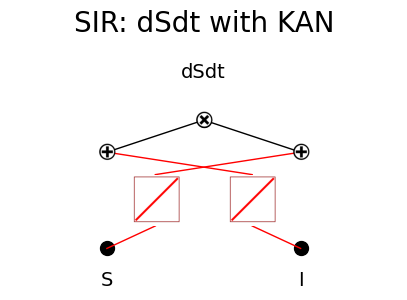

In [6]:
# Treinar o modelo. Substitua aqui o conjunto de parâmetros
model.fit(dataset, steps=50, lamb=1e-15, lamb_coef=1e-5);

model.plot(beta = 15, in_vars=['S','I'], out_vars=['dSdt'], title = 'SIR: dSdt with KAN', scale=0.50, varscale=0.7)
# if you want to rename your variables, you could use the "var" argument
formula, variables = model.symbolic_formula(var=['S', 'I'])
formula

In [7]:
from kan.utils import ex_round
from sympy import *

ex_round(expand(ex_round(model.symbolic_formula(var=['S', 'I'])[0][0],5)),3)

-0.3*I*S

# dIdt 

In [8]:
# Importar o arquivo CSV para um DataFrame do pandas
dados = pd.read_csv('C:/Users/beatr/Desktop/MySindy/pysindy/DadosArt1/dados_sir.csv')
# Construíndo arrays com dados S, I, R
S = np.array(dados['suscetiveis'])
I = np.array(dados['infectados'])

dSdt_real = np.array(dados['dSdt'])
dIdt_real = np.array(dados['dIdt'])
dRdt_real =np.array(dados['dRdt'])

# Converter dados para tensores PyTorch
S_tensor = torch.tensor(S, dtype=torch.float64)
I_tensor = torch.tensor(I, dtype=torch.float64)

dSdt_tensor = torch.tensor(dSdt_real, dtype=torch.float64) # dSdt = -beta * S * I + nu * R
dIdt_tensor = torch.tensor(dIdt_real, dtype=torch.float64).unsqueeze(1)   # beta * S * I - gamma * I
dRdt_tensor = torch.tensor(dRdt_real, dtype=torch.float64)

# Combinar S, I e R em um tensor de entrada
inputs_tensor = torch.stack((S_tensor, I_tensor), dim=1)

# Combinar as derivadas em um único tensor de saída
outputs_tensor = dIdt_tensor

# Converter tensores para arrays NumPy para usar com train_test_split
inputs_np = inputs_tensor.numpy()
outputs_np = outputs_tensor.numpy()

# Dividir os dados em conjuntos de treino e teste
x_train, x_test, y_train, y_test = train_test_split(inputs_np, outputs_np, test_size=0.2, random_state=42)

# Converter os conjuntos de treino e teste de volta para tensores PyTorch
x_train_tensor = torch.tensor(x_train, dtype=torch.float64)
x_test_tensor = torch.tensor(x_test, dtype=torch.float64)
y_train_tensor = torch.tensor(y_train, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test, dtype=torch.float64)

# Criar o dataset
dataset = {
    'train_input': x_train_tensor,
    'train_label': y_train_tensor,
    'test_input': x_test_tensor,
    'test_label': y_test_tensor
}

# Verifique os resultados:
#print("Train input shape:", dataset['train_input'].shape)
#print("Test input shape:", dataset['test_input'].shape)
#print("Train label shape:", dataset['train_label'].shape)
#print("Test label shape:", dataset['test_label'].shape)
dataset['train_input'].shape, dataset['train_label'].shape
#dataset
#dataset['test_input'].shape, dataset['test_label'].shape7


(torch.Size([40000, 2]), torch.Size([40000, 1]))

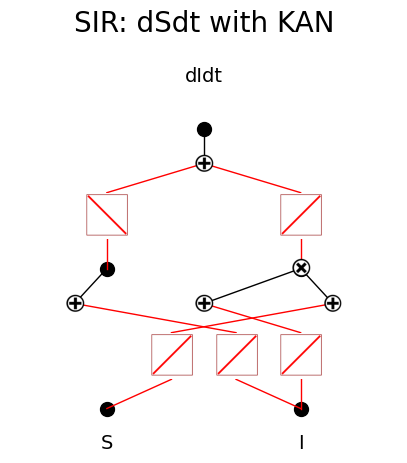

In [9]:
from kan.compiler import kanpiler
from sympy import symbols
import torch
# Definir dispositivo 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definindo as variáveis simbólicas
S, I = symbols('S I')
expr = S * I-I  # A equação que você deseja ajustar

# Criar o modelo KAN a partir da equação simbólica
model = kanpiler([S, I], expr).to(device)  # Certifique-se que está na GPU (se disponível)
model.get_act(dataset)  # Visualiza as ativações antes de ajustar
model.plot(beta=15, in_vars=['S', 'I'], out_vars=['dIdt'], title='SIR: dSdt with KAN', scale=0.50, varscale=0.7)


| train_loss: 1.26e-12 | test_loss: 6.87e-13 | reg: 2.14e-05 | : 100%|█| 30/30 [00:24<00:00,  1.22it


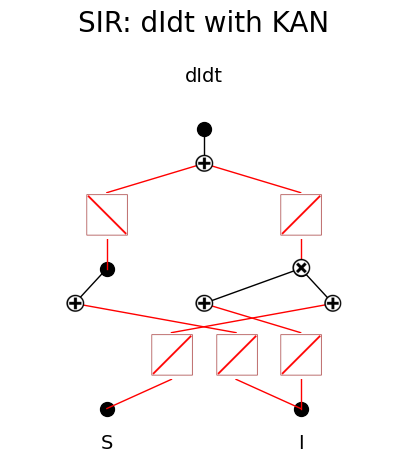

In [10]:
# Treinar o modelo. Substitua aqui o conjunto de parâmetros
model.fit(dataset, steps=30, lamb=1e-15, lamb_coef=1e-5);
model.plot(beta = 15, in_vars=['S','I'], out_vars=['dIdt'], title = 'SIR: dIdt with KAN', scale=0.50, varscale=0.7)


In [11]:
from kan.utils import ex_round
from sympy import *

ex_round(expand(ex_round(model.symbolic_formula(var=['S', 'I'])[0][0],5)),3)

0.3*I*S - 0.1*I

# dRdt

In [21]:
# Importar o arquivo CSV para um DataFrame do pandas
dados = pd.read_csv('C:/Users/beatr/Desktop/MySindy/pysindy/DadosArt1/dados_sir.csv')
# Construíndo arrays com dados S, I, R
S = np.array(dados['suscetiveis'])
I = np.array(dados['infectados'])

dSdt_real = np.array(dados['dSdt'])
dIdt_real = np.array(dados['dIdt'])
dRdt_real =np.array(dados['dRdt'])

# Converter dados para tensores PyTorch
S_tensor = torch.tensor(S, dtype=torch.float64)
I_tensor = torch.tensor(I, dtype=torch.float64).unsqueeze(1)

dSdt_tensor = torch.tensor(dSdt_real, dtype=torch.float64) # dSdt = -beta * S * I + nu * R
dIdt_tensor = torch.tensor(dIdt_real, dtype=torch.float64)   # beta * S * I - gamma * I
dRdt_tensor = torch.tensor(dRdt_real, dtype=torch.float64).unsqueeze(1)

# Combinar S, I e R em um tensor de entrada
inputs_tensor = I_tensor

# Combinar as derivadas em um único tensor de saída
outputs_tensor = dRdt_tensor

# Converter tensores para arrays NumPy para usar com train_test_split
inputs_np = inputs_tensor.numpy()
outputs_np = outputs_tensor.numpy()

# Dividir os dados em conjuntos de treino e teste
x_train, x_test, y_train, y_test = train_test_split(inputs_np, outputs_np, test_size=0.2, random_state=42)

# Converter os conjuntos de treino e teste de volta para tensores PyTorch
x_train_tensor = torch.tensor(x_train, dtype=torch.float64)
x_test_tensor = torch.tensor(x_test, dtype=torch.float64)
y_train_tensor = torch.tensor(y_train, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test, dtype=torch.float64)

# Criar o dataset
dataset = {
    'train_input': x_train_tensor,
    'train_label': y_train_tensor,
    'test_input': x_test_tensor,
    'test_label': y_test_tensor
}

# Verifique os resultados:
#print("Train input shape:", dataset['train_input'].shape)
#print("Test input shape:", dataset['test_input'].shape)
#print("Train label shape:", dataset['train_label'].shape)
#print("Test label shape:", dataset['test_label'].shape)
dataset['train_input'].shape, dataset['train_label'].shape
#dataset
#dataset['test_input'].shape, dataset['test_label'].shape7


(torch.Size([40000, 1]), torch.Size([40000, 1]))

checkpoint directory created: ./model
saving model version 0.0


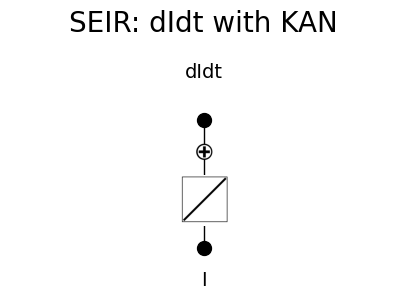

In [22]:
######                 NÃO EXECULTE 
# TENTE DESSA FORMA TAMBÉM
from kan import KAN
import torch
# dSdt = -beta * S * I - nu * R
# Definir dispositivo 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

# Inicializar o modelo KAN
#model = KAN(width=[3,[0,2], 1], base_fun='identity',mult_arity=2,  device=device, seed=42)

model = KAN(width=[1,1], grid=3, base_fun='identity',seed=12) #base_fun='identity',
#model = KAN(width=[3, 5, 1], device=device)  # Ajustar a largura conforme necessário
model.get_act(dataset)
model.plot(beta=15, in_vars=['I'], out_vars=['dIdt'], title='SEIR: dIdt with KAN', scale=0.50, varscale=0.7)


| train_loss: 1.90e-10 | test_loss: 1.91e-10 | reg: 1.34e+00 | : 100%|█| 50/50 [00:25<00:00,  1.95it


saving model version 0.1


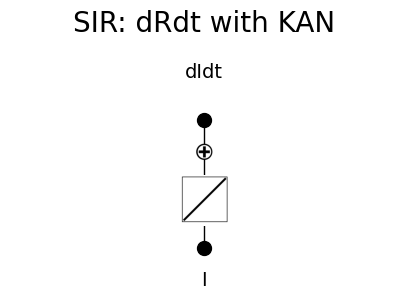

In [23]:
# Treinar o modelo novamente até encotrar precisão da máquina
model.fit(dataset, steps=50, lamb=1e-15, lamb_coef=1.0);
model.plot(beta = 15, in_vars=['I'], out_vars=['dIdt'], title = 'SIR: dRdt with KAN', scale=0.50, varscale=0.7)

In [24]:
model.suggest_symbolic(0,0,0)

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        x    1.000000 -16.608162           1                1   -2.521632
1      exp    1.000000 -16.606494           2                2   -1.721299
2      x^2    0.999999 -16.525125           2                2   -1.705025
3      cos    0.999998 -16.369858           2                2   -1.673972
4      sin    0.999998 -16.369858           2                2   -1.673972


('x',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  1,
  <function kan.utils.<lambda>(x, y_th)>),
 0.9999999897483871,
 1)

In [25]:
model.fix_symbolic(0,0,0,'x')

Best value at boundary.
r2 is 0.9999999897483871
saving model version 0.2


tensor(1.0000)

| train_loss: 2.86e-09 | test_loss: 7.27e-11 | reg: 4.60e-04 | : 100%|█| 30/30 [00:03<00:00,  9.85it


saving model version 0.3


[0.100000000729339*I - 6.27717738899136e-11]

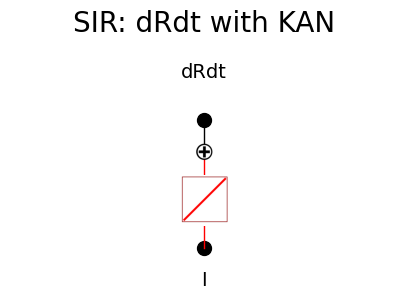

In [26]:
# Treinar o modelo. Substitua aqui o conjunto de parâmetros
model.fit(dataset, steps=30, lamb=1e-15, lamb_coef=1e-3);
model.plot(beta = 15, in_vars=['I'], out_vars=['dRdt'], title = 'SIR: dRdt with KAN', scale=0.50, varscale=0.7)
# if you want to rename your variables, you could use the "var" argument
formula, variables = model.symbolic_formula(var=['I'])
formula

In [27]:
from kan.utils import ex_round
from sympy import *

ex_round(expand(ex_round(model.symbolic_formula(var=['I'])[0][0],5)),3)

0.1*I